In [1]:
import numpy as np
import numpy.random as nrd
import numpy.linalg as nla

import matplotlib.pyplot as plt

from scipy.optimize import minimize
from csaps import csaps

from SOM import SelfOrganizingMaps

# Exercise 14.13

Generate 200 data points with three features, lying close to a
helix. In detail, define

- X1 = cos(s) + 0.1 · Z1
- X2 = sin(s) + 0.1 · Z2
- X3 = s + 0.1 · Z3

where s takes on 200 equally spaced values between 0 and 2π,
and Z1, Z2, Z3 are independent and have standard Gaussian distributions.

(a) Fit a principal curve to the data and plot the estimated coordinate functions. Compare them to the underlying functions cos(s),sin(s) and s.

(b) Fit a self-organizing map to the same data, and see if you can discover the helical shape of the original point cloud.

# Solution

Let's first generate the data and visualize them,

In [2]:
def helix(N,noise=0.1,rnd_seed=0):
    
    s = np.arange(0,2*np.pi,2*np.pi/N)
    rng = nrd.default_rng(seed=rnd_seed)
    
    X = np.vstack((np.cos(s),np.sin(s),s)).T
    
    return X + noise*rng.normal(size=(N,3))

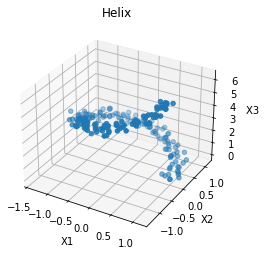

In [3]:
N = 200
X = helix(N)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:,0],X[:,1],X[:,2])

ax.set_title('Helix')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3 ')
plt.show()

# Principal Curve

Here is the class implementing the principal curve algorithm,

In [4]:
class PrincipalCurve():
    
    def __init__(self):
        pass
    
    # The smoothing method we use require that t is sorted
    def sort_xy(self,x,y):
        
        sorted_index = np.argsort(x)
        x_sort = x[sorted_index]
        y_sort = y[sorted_index]

        return x_sort, y_sort
    
    # Initialize the curve's parameter t for each observation
    def initialize_t(self,X):
        
        N,_ = X.shape
        
        X_mean = np.mean(X,axis=0)
        U,D,Vt = nla.svd(X-X_mean)
        
        return U[:,0] * D[0]
    
    # Updating step for the curve parameter
    def update_t(self):
        
        # This is the function we need to optimize
        def loss(t):
            y = 0
            for x, f in zip(X.T,self.smooth_features):
                y += (x - f(t)) @ (x - f(t))
            return y
        
        # We minimize the loss function using as starting point the previous t
        min_t = minimize(loss,self.t)
        
        # Raise exception is we fail
        if not min_t.success:
            raise RuntimeError(min_t.message)
            
        return min_t.x
    
    # Compute square residual between smooth model and data
    def squared_residuals(self,X):
        
        SSR = 0
        
        for x, f in zip(X.T,self.smooth_features):
            SSR += (x - f(self.t)) @ (x - f(self.t))
            
        return SSR
    
    # Fit the curve to the data
    def fit(self,X,max_iterations=50,smooth_param=0.8):
        
        N,_ = X.shape
        self.t = self.initialize_t(X)
        
        self.learning_curve = []
        
        for j in range(max_iterations):
            
            # fit a cubic spline to each feature vector
            self.smooth_features = []
            for x in X.T:
                self.smooth_features.append(csaps(*self.sort_xy(self.t,x),smooth=smooth_param))
                
            # update t, vector of parameters
            self.t = self.update_t()
                
            # compute square of residual to check on improvements
            self.learning_curve.append(self.squared_residuals(X))
        

Let's fit the model to the data,

In [5]:
model = PrincipalCurve()
model.fit(X)

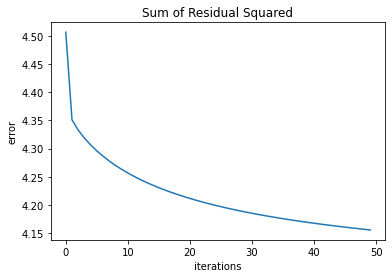

In [6]:
plt.plot(model.learning_curve,label='sum residual square')
plt.title('Sum of Residual Squared')
plt.xlabel('iterations')
plt.ylabel('error')
plt.show()

Let's visualize the curves,

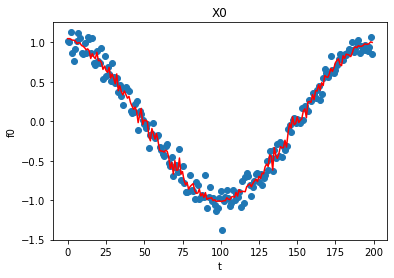

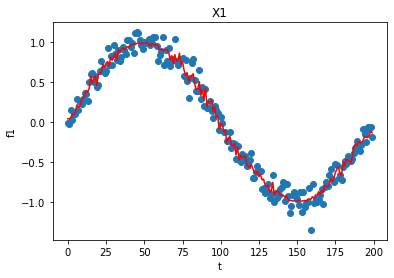

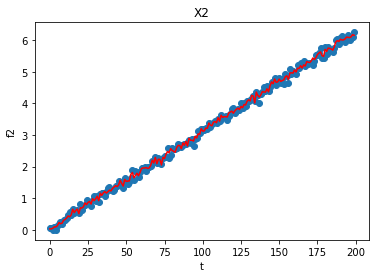

In [7]:
t = np.arange(0,N)

for i,f in enumerate(model.smooth_features):
    plt.scatter(t,X[:,i])
    plt.plot(f(model.t),c='red')
    plt.title('X{}'.format(i))
    plt.xlabel('t')
    plt.ylabel('f{}'.format(i))
    plt.show()

# SOM approach

Let's see if a Self-Organizing map is able to do the same,

In [43]:
# Number of prototypes per direction
grid_size = (100,)

# Dimension of SOM
q = 1

# Number of iterations for the training
epochs = 100
iterations = epochs*N

# Parameter of the model
alpha = 1.
r = 2.

# SOM model
model = SelfOrganizingMaps(grid_size,q)
model.fit(X,iterations,alpha,r)
SOM_error = model.learning_curve

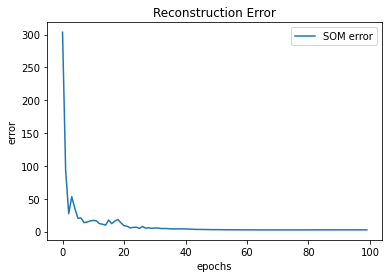

In [44]:
# Plot the reconstruction error for the two methods
plt.plot(SOM_error,label='SOM error')
plt.title('Reconstruction Error')
plt.xlabel('epochs')
plt.ylabel('error')
plt.legend()
plt.show()

We can plot the prototypes we find, and obtain the helix,

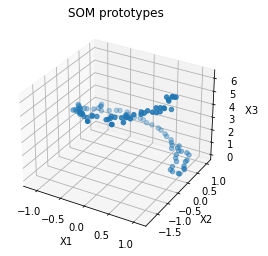

In [48]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

prototypes = np.array(list(model.prototypes.values()))

ax.scatter(prototypes[:,0],prototypes[:,1],prototypes[:,2])

ax.set_title('SOM prototypes')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3 ')
plt.show()

The prototypes do converge to the helix. But how do they look like as curves?

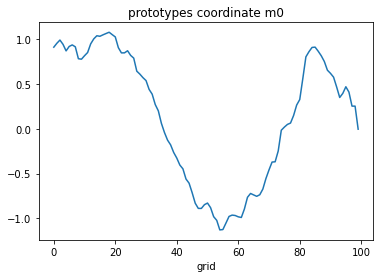

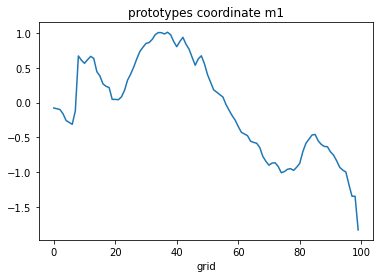

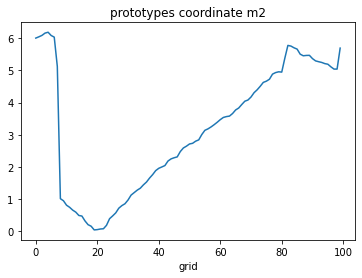

In [50]:
for i in range(p):
    plt.plot(prototypes[:,i])
    plt.title('prototypes coordinate m{}'.format(i))
    plt.xlabel('grid')
    plt.show()

Not really great honestly!